In [47]:
import dask.dataframe as dd
import dask.bag as db
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark.sql.functions import col, year, month
import pyspark.sql.functions as func
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [2]:
!PowerShell.exe gc "./data/yt_metadata_en.jsonl" -head 2

{"categories": "Film & Animation", "channel_id": "UCzWrhkg9eK5I8Bm3HfV-unA", "crawl_date": "2019-10-31 20:19:26.270363", "description": "Lego City Police Lego Firetruck Cartoons about Lego City Movie for kids with a nice long video to keep the kids entertained while learning and having fun with the Lego City characters from Lego City undercover. Thanks for watching!", "dislike_count": 1.0, "display_id": "SBqSc91Hn9g", "duration": 1159, "like_count": 8.0, "tags": "lego city,lego police,lego city police,lego city episodes,videos de lego city,lego policia,lego bomberos,lego fire truck,lego firetruck,lego police chase,lego robbers,lego cartoons,lego movies,lego videos for kids", "title": "Lego City Police Lego Firetruck Cartoons about Lego City Movie for kids Episodes", "upload_date": "2016-09-28 00:00:00", "view_count": 1057.0}
{"categories": "Film & Animation", "channel_id": "UCzWrhkg9eK5I8Bm3HfV-unA", "crawl_date": "2019-10-31 20:19:26.914516", "description": "Lego Marvel SuperHeroes Le

In [3]:
FILE = "data/yt_metadata_en.jsonl"
OUTPUT_FILE = "data/yt_metadata_en.csv"


schema = StructType([
    StructField("categories",    StringType(),  True),
    StructField("channel_id",    StringType(),  True),
    StructField("crawl_date",    DateType(),    True),
    StructField("dislike_count", StringType(),  True), # This field must be specified as a string as it is inputed as a floating point number
    StructField("display_id",    StringType(),  True),
    StructField("duration",      IntegerType(), True),
    StructField("like_count",    StringType(),  True), # This field must be specified as a string as it is inputed as a floating point number
    StructField("tags",          StringType(),  True),
    StructField("title",         StringType(),  True),
    StructField("upload_date",   DateType(),    True),
    StructField("view_count",    StringType(),  True)  # This field must be specified as a string as it is inputed as a floating point number
])

# {
#     'categorie'    : StringType,                           
#     'channel_id'   : StringType,                           
#     'crawl_date'   : DateType,                           
#     'dislike_count': IntegerType,                           
#     'display_id'   : StringType,                           
#     'duration'     : IntegerType,                           
#     'like_count'   : IntegerType,                           
#     'tags'         : StringType,                           
#     'title'        : StringType,                           
#     'upload_date'  : DateType,                           
#     'view_count'   : LongType                           
# }

In [4]:
df = spark.read.json(FILE, schema=schema)

In [5]:
df = df \
    .withColumn("dislike_count", df.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", df.like_count.cast(IntegerType())) \
    .withColumn("view_count", df.view_count.cast(LongType()))

In [6]:
df.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)



In [7]:
df.show(2, vertical=True)

-RECORD 0-----------------------------
 categories    | Film & Animation     
 channel_id    | UCzWrhkg9eK5I8Bm3... 
 crawl_date    | 2019-10-31           
 dislike_count | 1                    
 display_id    | SBqSc91Hn9g          
 duration      | 1159                 
 like_count    | 8                    
 tags          | lego city,lego po... 
 title         | Lego City Police ... 
 upload_date   | 2016-09-28           
 view_count    | 1057                 
-RECORD 1-----------------------------
 categories    | Film & Animation     
 channel_id    | UCzWrhkg9eK5I8Bm3... 
 crawl_date    | 2019-10-31           
 dislike_count | 1                    
 display_id    | UuugEl86ESY          
 duration      | 2681                 
 like_count    | 23                   
 tags          | Lego superheroes,... 
 title         | Lego Marvel Super... 
 upload_date   | 2016-09-28           
 view_count    | 12894                
only showing top 2 rows



In [8]:
df.select("dislike_count", "duration", "like_count", "view_count").summary().show()

+-------+-----------------+------------------+------------------+------------------+
|summary|    dislike_count|          duration|        like_count|        view_count|
+-------+-----------------+------------------+------------------+------------------+
|  count|         71293335|          72924794|          71293314|          72847198|
|   mean|75.85430918612518| 757.6761375561788|1302.3894336290778| 89859.75928299947|
| stddev| 2319.24547755486|1820.1105064271235|18234.302834924434|1934762.8235496785|
|    min|                0|                 1|                 0|                 0|
|    25%|                0|               134|                 6|               531|
|    50%|                2|               284|                43|              2915|
|    75%|               12|               697|               265|             17306|
|    max|          4506614|            360157|           9969034|        3709532958|
+-------+-----------------+------------------+------------------+

In [9]:
df.count()

72924794

In [24]:
# Extract year from upload_date
df_dates = df\
    .withColumn("year", year(df.upload_date))\
    .withColumn("month", month(df.upload_date))
df_dates.printSchema()

root
 |-- categories: string (nullable = true)
 |-- channel_id: string (nullable = true)
 |-- crawl_date: date (nullable = true)
 |-- dislike_count: integer (nullable = true)
 |-- display_id: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- title: string (nullable = true)
 |-- upload_date: date (nullable = true)
 |-- view_count: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [27]:
vids_per_month = df_dates.select("display_id", "year", "month").groupBy("year", "month").count()

In [40]:
count = vids_per_month.toPandas()

In [45]:
count_sorted = count.sort_values(["year", "month"])

In [58]:
count_sorted["date"] = pd.to_datetime(count_sorted["year"].astype(str) + count_sorted["month"].astype(str), format="%Y%m")

In [65]:
plt.style.use("ggplot")

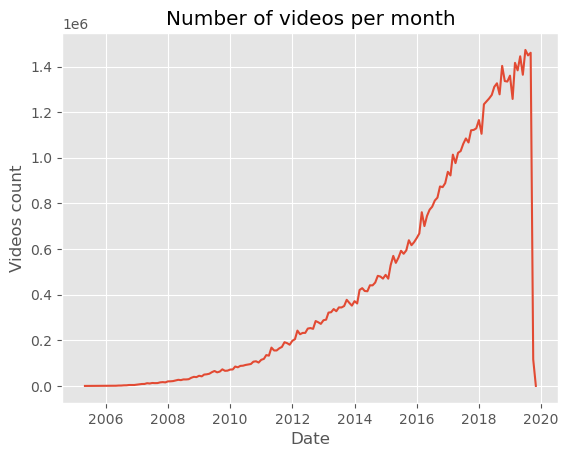

In [70]:
sns.lineplot(data=count_sorted, x="date", y="count")
plt.title("Number of videos per month")
plt.xlabel("Date")
plt.ylabel("Videos count")
plt.show()